<a href="https://colab.research.google.com/github/diankaryoko/Time-Series-Dicoding-Project/blob/main/Dian_Karyoko_Time_Series_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dian Karyoko, DKI Jakarta**

Dalam project ini, akan diolah data time series menggunakan LSTM. Dataset ini adalah data harga saham perusahaan Apple (AAPL) dari IPO hingga tahun 2020, yang totalnya berjumlah 10015 baris. Data yang akan dipakai hanya data di kolom "Open", yaitu harga pembukaan saham setiap harinya.

In [ ]:
# Mengimport library yang dibutuhkan
import numpy as np
import pandas as pd

from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Mengupload data berupa file csv
from google.colab import files
uploaded = files.upload()

Saving AAPL.csv to AAPL.csv


In [ ]:
# Mengubah file csv menjadi dataframe
df = pd.read_csv('AAPL.csv')
print(df)

             Date        Open        High  ...       Close   Adj Close       Volume
0      1980-12-12    0.128348    0.128906  ...    0.128348    0.101261  469033600.0
1      1980-12-15    0.122210    0.122210  ...    0.121652    0.095978  175884800.0
2      1980-12-16    0.113281    0.113281  ...    0.112723    0.088934  105728000.0
3      1980-12-17    0.115513    0.116071  ...    0.115513    0.091135   86441600.0
4      1980-12-18    0.118862    0.119420  ...    0.118862    0.093777   73449600.0
...           ...         ...         ...  ...         ...         ...          ...
10011  2020-08-26  126.180000  126.992500  ...  126.522499  126.522499  163022400.0
10012  2020-08-27  127.142502  127.485001  ...  125.010002  125.010002  155552400.0
10013  2020-08-28  126.012497  126.442497  ...  124.807503  124.807503  187630000.0
10014  2020-08-31  127.580002  131.000000  ...  129.039993  129.039993  225702700.0
10015  2020-09-01  132.759995  134.800003  ...  134.179993  134.179993  1519

In [ ]:
# Mengecek apakah ada nilai yang hilang
df.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [ ]:
# Memeriksa baris yang nilainya hilang
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

print(rows_with_NaN)

           Date  Open  High  Low  Close  Adj Close  Volume
165  1981-08-10   NaN   NaN  NaN    NaN        NaN     NaN


Dari output di atas, dapat diketahui bahwa data harga saham Apple pada tanggal 10 Agustus 1981 hilang. Oleh karena itu, nilai NaN tersebut akan diganti dengan rata-rata nilai pada baris ke 164 dan baris ke 166. 

Saya hanya menggunakan rata-rata dari kedua data tersebut dan **bukan menggunakan rata-rata keseluruhan nilai dari data pertama sampai terakhir**, karena data ini bukan data biasa melainkan data time series, dan di data time series ini terdapat trend (pola naik/turun nya data). Jika saya menggunakan rata-rata keseluruhan, maka kemungkinan hasil rata-rata tersebut akan sangat berbeda jauh dengan kenyataan sesungguhnya karena 'tertarik' oleh data-data di tahun-tahun terbaru (tahun 2020) yang kondisinya sudah jelas berbeda dengan data pada tahun 1981. 

Saya juga hanya akan mengisi NaN pada kolom 'Open', karena saya hanya akan menggunakan data pada kolom tersebut.

In [ ]:
# Menhitung rata-rata dari harga pembukaan di kolom 164 dan 166
print((df.Open[164]+df.Open[166])/2)

0.11160700000000001


In [ ]:
# Mengganti nilai NaN di kolom Open baris 165 dengan rata-rata yang didapatkan
df = df.fillna(value = {'Open': 0.11160700000000001})

#Mengecek apakah nilai sudah terganti
df.Open[165]

0.11160700000000001

In [ ]:
# Menampilkan ringkasan dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10016 non-null  object 
 1   Open       10016 non-null  float64
 2   High       10015 non-null  float64
 3   Low        10015 non-null  float64
 4   Close      10015 non-null  float64
 5   Adj Close  10015 non-null  float64
 6   Volume     10015 non-null  float64
dtypes: float64(6), object(1)
memory usage: 547.9+ KB


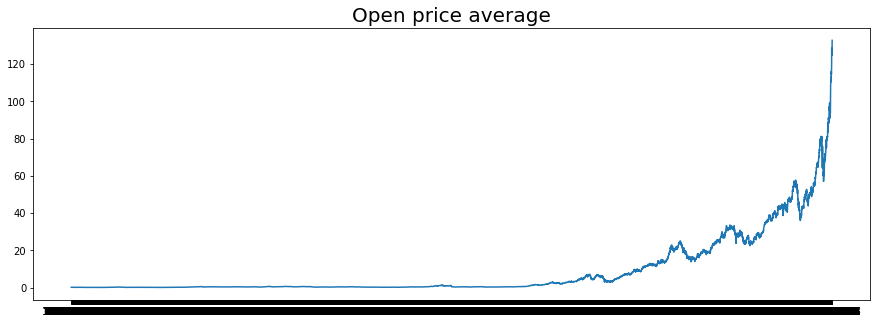

In [ ]:
# Plot data
dates = df['Date'].values
price = df['Open'].values

plt.figure(figsize=(15,5))
plt.plot(dates, price)
plt.title('Open price average', fontsize=20);

Dapat terlihat bahwa data tersebut bukan data musiman, dan memiliki trend naik.

In [ ]:
# Membagi data menjadi training set dan validation set
from sklearn.model_selection import train_test_split
date_train, date_valid, price_train, price_valid = train_test_split(dates, price, train_size=0.8, test_size = 0.2, shuffle = False )

In [ ]:
# Mengubah format data
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
# Membangun model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import regularizers

train_set = windowed_dataset(price_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(price_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [ ]:
# Menghitung MAE
MAE = 0.1*(max(df.Open)-min(df.Open))
print(MAE)

13.271033000000001


In [ ]:
# Menerapkan callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<MAE):
      print("\nMAE sudah dibawah ", MAE , ", train data diberhentikan.")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# Melatih model
history = model.fit(train_set, epochs=100, callbacks=[callbacks])

Epoch 1/100
80/80 [==============================] - 13s 162ms/step - loss: 13.1724 - mae: 13.6626
Epoch 2/100
80/80 [==============================] - 13s 162ms/step - loss: 7.7515 - mae: 8.2496

MAE sudah dibawah  13.271033000000001 , train data diberhentikan.
